<a href="https://colab.research.google.com/github/asuzukosi/ReinforcementLearningForAGI/blob/main/src/DQN/DeepReinforcmentLearning_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Deep Q-Networks
In this notebook, we will explore the implementation of the base vanilla DQN algorithm to the rainbow DQN. We will explore the use of these algorithms across various gym environments. We will use 3 environments for each model.

#### Install required libraries
We will install the required libraries for environments and models we need

In [6]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt-get install -y python3-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium==0.28.1
    from pyvirtualdisplay import Display

    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 19 not upgraded.
Need to get 891 kB/7,812 kB of archives.
After this operation, 11.9 M

FileNotFoundError: ignored

In [7]:
!pip install torch
!pip install pyglet
!pip install gymnasium[classic-control]
!pip install PyVirtualDisplay
!pip install moviepy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 854.7/854.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 48.0 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


#### Import required libraries
In this section we will import all the required libraries to implement our algorithms

In [3]:
import torch
import os
from typing import Dict, List, Tuple
import gymnasium as gym
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


#### Replay Buffer
Replay buffer is used to store the previous experiences in order to stabilize training of the DQN.
The replay buffer is implemented in one of the following
- numpy
- dequeue
- list

In our implementation of the replay buffer we will be using numpy arrays as they benefit for locality of reference, so this well speed up the retreival time of items

In [4]:
class ReplayBuffer:
  def __init__(self, obs_dim:int, size:int, batch_size:int=32):
    # we create empty lists to store the information in the buffers
    self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.acts_buf = np.zeros([size], dtype=np.float32)
    self.rews_buf = np.zeros([size], dtype=np.float32)
    self.done_buf = np.zeros(size, dtype=np.float32)
    # set the batch size and the maximum size of the replay buffer
    self.max_size, self.batch_size = size, batch_size
    # set the pointer value and the size value
    self.ptr, self.size, = 0, 0

  def store(self, obs, action, reward, next_obs, done):
    self.obs_buf[self.ptr] = obs
    self.next_obs_buf[self.ptr] = next_obs
    self.acts_buf[self.ptr] = action
    self.rews_buf[self.ptr] = reward
    self.done_buf[self.ptr] = done
    # set the pointer value to the modulus of the max size and the current pointer +1
    self.ptr = (self.ptr + 1) % self.max_size
    # if the size exceeds the max size, set the value to max size
    self.size = min(self.size + 1, self.max_size)


  def sample(self):
    idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
    return dict(obs=self.obs_buf[idxs],
                acts=self.acts_buf[idxs],
                rews=self.rews_buf[idxs],
                next_obs=self.next_obs_buf[idxs],
                done=self.done_buf[idxs])
  def __len__(self):
    return self.size

#### Network implementation
In this section we will focus on implementing the neural network for our DQN algorithm

In [5]:
class Network(nn.Module):
  def __init__(self, inp_dim:int, out_dim:int, hidden_dim=128):
    # initiation
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(inp_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, out_dim), # We are returning the actual values of the actions
    )

  def forward(self, x):
    # equation
    return self.layers(x)

In [26]:
class DQNAgent:
  """
  This class handles the training and inference of
  the DQN agent class
  """
  def __init__(self, env, memory_size:int, batch_size,
               target_update, epsilon_decay, seed,
               max_epsilon:float=1.0, min_epsilon:float=0.1,
               gamma:float=0.99):
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n

    self.env = env
    self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
    self.batch_size = batch_size
    self.epsilon = max_epsilon
    self.epsilon_decay = epsilon_decay
    self.seed = seed
    self.max_epsilon = max_epsilon
    self.min_epsilon = min_epsilon
    self.target_update = target_update
    self.gamma = gamma # discout factor

    self.obs_dim = obs_dim
    self.act_dim = act_dim

    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.dqn = Network(obs_dim, act_dim).to(self.device)
    self.dqn_target = Network(obs_dim, act_dim).to(self.device)
    self.dqn_target.load_state_dict(self.dqn.state_dict())
    self.dqn_target.eval()

    self.optimizer = optim.Adam(self.dqn.parameters())
    self.transitions = list()
    self.is_test = False


  def select_action(self, obs):
    # select an action given an observation
    if self.epsilon > np.random.random():
      selected_action = self.env.action_space.sample()
    else:
      selected_action = self.dqn(torch.FloatTensor(obs).to(self.device)).argmax()
      selected_action = selected_action.detach().cpu().numpy()
    if not self.is_test:
      self.transition = [obs, selected_action]

    return selected_action

  def step(self, action):
    """Take an action and return the response of the env."""
    next_state, reward, terminated, truncated, _ = self.env.step(action)
    done = terminated or truncated

    if not self.is_test:
      self.transition += [reward, next_state, done]
      self.memory.store(*self.transition)

    return next_state, reward, done


  def update_model(self):
    samples = self.memory.sample()
    loss = self._compute_dqn_loss(samples)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    return loss.item()


  def _compute_dqn_loss(self, samples):
    # return computed dqn loss
    device = self.device  # for shortening the following lines
    state = torch.FloatTensor(samples["obs"]).to(device)
    next_state = torch.FloatTensor(samples["next_obs"]).to(device)
    action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
    reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
    done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

    curr_q_value = self.dqn(state).gather(1, action)
    next_q_value = self.dqn_target(
            next_state
        ).max(dim=1, keepdim=True)[0].detach()
    mask = 1 - done
    target = (reward + self.gamma * next_q_value * mask).to(self.device)
    # calculate dqn loss
    loss = F.smooth_l1_loss(curr_q_value, target)
    return loss

  def train(self, num_frames, plotting_interval:int=200):
    """
    Train the RL agent
    """
    self.is_test = False
    state, _ = self.env.reset(seed=self.seed)
    update_cnt = 0
    epsilons = []
    losses = []
    scores = []
    score = 0

    for frame_idx in range(0, num_frames+1):
      action = self.select_action(state)
      next_state, reward, done = self.step(action)

      state = next_state
      score += reward

      # if episode ends
      if done:
          state, _ = self.env.reset(seed=self.seed)
          scores.append(score)
          score = 0

      # if training is ready
      if len(self.memory) >= self.batch_size:
          loss = self.update_model()
          losses.append(loss)
          update_cnt += 1

          # linearly decrease epsilon
          self.epsilon = max(
              self.min_epsilon, self.epsilon - (
                  self.max_epsilon - self.min_epsilon
              ) * self.epsilon_decay
          )
          epsilons.append(self.epsilon)

          # if hard update is needed
          if update_cnt % self.target_update == 0:
              self._target_hard_update()

      # plotting
      if frame_idx % plotting_interval == 0:
          self._plot(frame_idx, scores, losses, epsilons)

    self.env.close()


  def test(self, video_folder:str):
    """Test the agent."""
    self.is_test = True

    # for recording a video
    naive_env = self.env
    # create new environment for recording video
    self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)

    state, _ = self.env.reset(seed=self.seed)
    done = False
    score = 0

    # we run only a single episode of the environment
    while not done:
      action = self.select_action(state)
      next_state, reward, done = self.step(action)

      state = next_state
      score += reward

    print("score: ", score)
    self.env.close()

    # reset
    self.env = naive_env

  def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

  def _plot(
      self,
      frame_idx: int,
      scores: List[float],
      losses: List[float],
      epsilons: List[float],
  ):
      """Plot the training progresses."""
      clear_output(True)
      plt.figure(figsize=(20, 5))
      plt.subplot(131)
      plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
      plt.plot(scores)
      plt.subplot(132)
      plt.title('loss')
      plt.plot(losses)
      plt.subplot(133)
      plt.title('epsilons')
      plt.plot(epsilons)
      plt.show()



#### Environment
Here we setup the environment for the experiment, we will be using the 2d cartpole environment

In [52]:
!apt-get install swig3.0
!pip install swig
!pip install gymnasium[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig3.0 is already the newest version (3.0.12-2.2ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
  Using cached swig-4.1.1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373077 sha256=e0704df630b78e390dd5612e47b3367ca8ae47d717d4c296efaedb7c432c0ac9
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [53]:
# environment
env = gym.make("LunarLander-v2", max_episode_steps=200, render_mode="rgb_array")

In [55]:
env.observation_space.sample()

array([-29.93665   ,  83.948746  ,   4.995944  ,  -1.7844111 ,
        -2.5391252 ,   4.2003303 ,   0.3408827 ,   0.35302174],
      dtype=float32)

In [56]:
# set the random seed to control variabilty of the experiment
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

In [58]:
# parameters
num_frames = 1000000
memory_size = 1000
batch_size = 32
target_update = 100
epsilon_decay = 1 / 2000
video_folder="videos/dqn/lunar_lander"

agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay, seed)

In [59]:
agent.epsilon_decay

0.0005

#### Train and Test DQN model
In this section we will train and test the DQN model iteratively on the cartpole environment

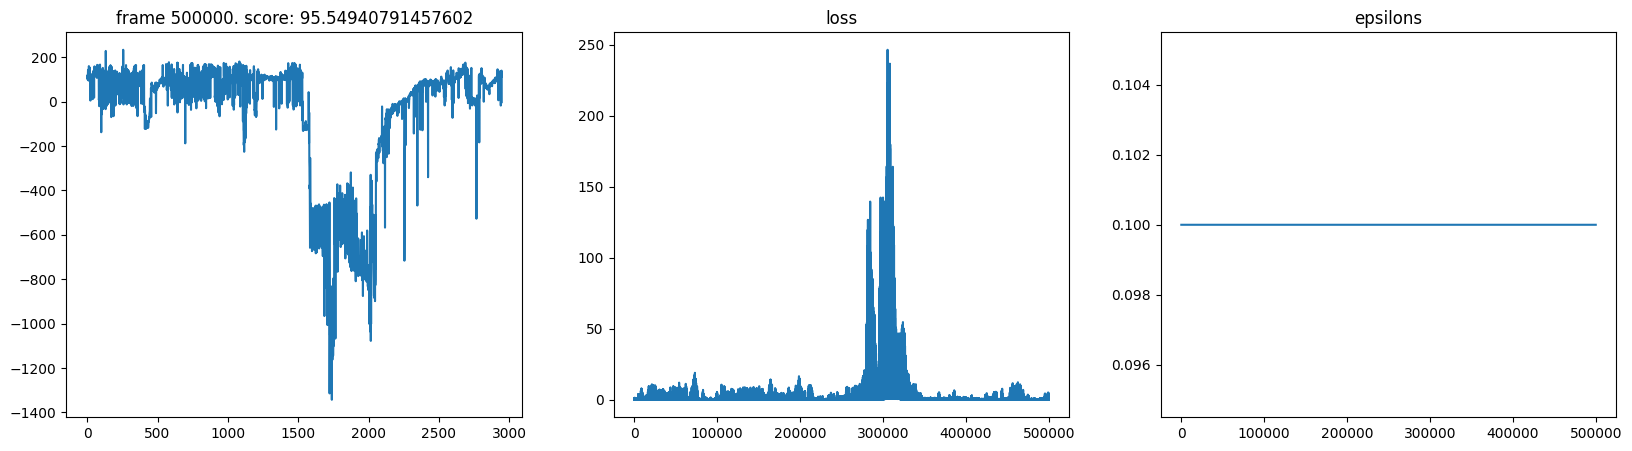

In [67]:
agent.train(num_frames=num_frames-500000)

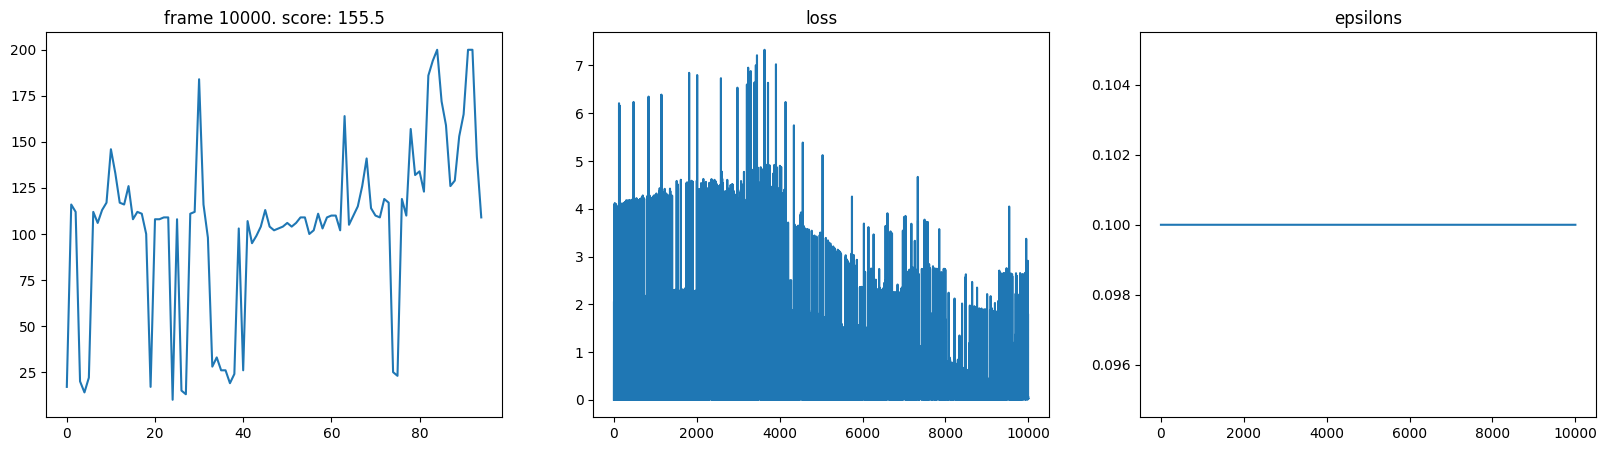

In [32]:
agent.train(num_frames=num_frames)

In [70]:
agent.test(video_folder)

Moviepy - Building video /content/videos/dqn/lunar_lander/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/dqn/lunar_lander/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/dqn/lunar_lander/rl-video-episode-0.mp4
score:  115.31250751790564


#### Render Video
In this section we will render the video that was generated during the testing of the agent model

In [71]:
import base64
import glob
import io
import os
from typing import List

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))


def show_latest_video(video_folder: str) -> List[str]:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    for file in list_of_files:
      ipython_show_video(file)
    return list_of_files


list_of_files = show_latest_video(video_folder=video_folder)
print("Played:", list_of_files)

Played: ['videos/dqn/lunar_lander/rl-video-episode-0.mp4']


This is awesomeeee!!!!!!!

### Double DQN
Double DQN is a modification of the DQN that tries to mitigate the over optimistic values of the Q network. So it proposes to use a different network for value estimation in the training. It will use the target network as this seperate network.

In [8]:
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gymnasium as gym

#### Replay Buffer
We implement the replay buffer for storing previous experiences that our agent has experienced, and then we sample from them during training.

In [10]:
class ReplayBuffer:
  def __init__(self, obs_dim, size, batch_size=32):
    self.obs_buf = np.zeros((size, obs_dim))
    self.next_obs_buf = np.zeros((size, obs_dim))
    self.act_buf = np.zeros((size))
    self.rews_buf = np.zeros((size))
    self.done_buf = np.zeros((size))

    self.max_size = size
    self.size, self.index = 0, 0

    self.batch_size = batch_size

  def store(self, obs, action, score, next_obs, done):
    self.obs_buf[self.index] = obs
    self.act_buf[self.index] = action
    self.rews_buf[self.index] = score
    self.next_obs_buf[self.index] = next_obs
    self.done_buf[self.index] = next_obs

    self.index = (self.index +  1 ) % self.max_size
    self.size = min(self.size + 1, self.max_size)


  def __len__(self):
    return self.size


  def sample(self):
    idxs = np.random.choice(self.size, self.batch_size, replace = False)
    return dict(obs=self.obs_buf[idxs],
                acts=self.act_buf[idxs],
                rews=self.rews_buf[idxs],
                next_obs=self.next_obs_buf[idxs],
                done = self.done_buf[idxs])


#### Neural Network
We implement the neural network that si used by our agent to learn the value function for the various state action pairs

In [9]:
class Network(nn.Module):
  def __init__(self, inp_dim:int , out_dim:int , hidden_dim:int=256):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(inp_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, out_dim)
        )

  def forward(self, state):
    return self.layers(state)

#### Implement full DQN architecture
In this section we will be implementing the full DQN agent set with training and testing implmented

In [ ]:
class Double_DQNAgent:
  def __init__(self, env, memory_size:int,
               batch_size:int, epsilon_decay:float,
               target_update:int, seed:int,
               max_epsilon:float=1.0, min_epsilon:float=0.1,
               gamma:float=0.99):
    self.env = env
    self.action_size = self.env.action_space.n
    self.obs_size = self.env.observation_space.shape[0]
    self.memory = ReplayBuffer(self.obs_size, memory_size, batch_size)
    self.batch_size = batch_size
    self.epsilon = max_epsilon
    self.epsilon_decay = epsilon_decay
    self.seed = seed
    self.max_epsilon = max_epsilon
    self.min_epsilon = min_epsilon
    self.target_update = target_update
    self.gamma = gamma
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.dqn = Network(self.obs_size, self.action_size).to(self.device)
    self.dqn_target = Network(self.obs_size, self.action_size).to(self.device)
    self.dqn_target.load_state_dict(self.dqn.state_dict())
    self.dqn_target.eval()

    self.optimizer = optim.Adam(self.dqn.parameters())
    self.transitions = list()
    # mode: train / test
    self.is_test = False

  def select_action(self, state):
    if self.epsilon > np.random.random():
      selected_action = self.env.action_space.sample()
    else:
      selected_action = self.dqn(torch.Tensor(state).to(self.device)).argmax()
      selected_action = selected_action.detach().cpu().numpy()

    if not self.is_test:
            self.transition = [state, selected_action]

    return selected_action

  def step(self, action):
    next_obs, reward, terminated, truncated = self.env.step(action)
    done = terminated or truncated
    if not self.is_test:
      self.transitions += [reward, next_obs, done]
      self.memory.store(*self.transition)
    return next_obs, reward, done


  def update_model(self):
    samples = self.memory.sample()
    loss = self._compute_loss(samples)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    return loss.item()

  def _compute_loss(self, samples):
    device = self.device  # for shortening the following lines
    state = torch.FloatTensor(samples["obs"]).to(device)
    next_state = torch.FloatTensor(samples["next_obs"]).to(device)
    actions = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
    reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
    done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

    curr_value = self.dqn(state).gather(1, actions)
    next_value = self.dqn_target(next_state).gather(1,
                                                    self.dqn(state).argmax(dim=1, keepdim=True)).detach()

    mask = 1 - done
    target = (reward + self.gamma * next_value * mask).to(self.device)
    loss = F.smooth_l1_loss(curr_value, target)

    return loss


  def _target_hard_update(self):
    self.dqn_target.load_state_dict(self.dqn.state_dict())



  def train(self, num_frames:int, plotting_interval:int=200):
    self.is_test = False
    state, _ = self.env.reset(seed=self.seed)
    update_cnt = 0
    epsilons = []
    losses = []
    scores = []
    score = 0

    for frame_idx in range(1, num_frames + 1):
      action = self.select_action(state)
      next_state, reward, done = self.step(action)

      state = next_state
      score += reward

      # if episode ends
      if done:
        state, _ = self.env.reset(seed=self.seed)
        scores.append(score)
        score = 0

      # if training is ready
      if len(self.memory) >= self.batch_size:
        loss = self.update_model()
        losses.append(loss)
        update_cnt += 1

        # linearly decrease epsilon
        self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
        epsilons.append(self.epsilon)

        # if hard update is needed
        if update_cnt % self.target_update == 0:
          self._target_hard_update()

        # plotting
      if frame_idx % plotting_interval == 0:
        self._plot(frame_idx, scores, losses, epsilons)

    self.env.close()



  def test(self, video_folder):
    native_env = self.env
    self.env = gym.wrappers.RecordVideo(native_env, video_folder=video_folder)
    state, _ = self.env.reset()
    done = False
    score = 0

    while not done:
      action = self.select_action(state)
      next_state, reward, done = self.step(action)

      state = next_state
      score += reward


    print("score: ", score)
    self.env.close()

    self.env = native_env


  def _plot(self,
        frame_idx: int,
        scores: List[float],
        losses: List[float],
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

#### Environment
In this section we will work on setting up the environment for double dqn with gymnassium

In [ ]:
env = gym.make("CartPole-v1", max_episode_steps=200, render_mode="rgb_array")

#### Experiment setup
In this section we will be setting up the experiment to train the double dqn algorithm

In [ ]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

In [ ]:
# parameters
num_frames = 10000
memory_size = 1000
batch_size = 32
target_update = 200
epsilon_decay = 1 / 2000

# train
agent = Double_DQNAgent(env, memory_size, batch_size, epsilon_decay, target_update, seed)

In [ ]:
agent.train(num_frames)

In [ ]:
video_folder = "video/double_dqn/cart_pole"
agent.test(video_folder)

In [ ]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)